In [1]:
import zipfile
import os
import os.path 
import nibabel as nib
import numpy as np
import pandas as pd
import shutil
import random
import re

In [ ]:
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(data, key=alphanum_key)


In [2]:
import nibabel as nib
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import random
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
import glob
import tifffile as tiff
from tifffile import imsave
from PIL import Image
import tensorflow as tf
import cv2 as cv
from PIL import Image
import random

In [ ]:
def applyClahe(img):
    clahe = cv.createCLAHE(clipLimit=3.0)
    claheImage = clahe.apply(np.uint8(img*255))
    return claheImage

In [3]:
from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from keras.metrics import MeanIoU
from keras.preprocessing.image import ImageDataGenerator

In [4]:
pip install segmentation-models-3D

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 5.9 MB/s 
     |████████████████████████████████| 62 kB 980 kB/s 


In [5]:
import segmentation_models_3D as sm
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

Segmentation Models: using `tf.keras` framework.


In [ ]:
BACKBONE = 'densenet201'


In [ ]:
import os 
import numpy as np
import matplotlib.pyplot as plt
import random
import tifffile as tiff
from tifffile import imread

def load_img(img_dir, img_list):
    images=[]
    for i, image_name in enumerate(img_list):    
        if (image_name.split('.')[1] == 'npy'):
            
            image = np.load(img_dir+image_name).astype(np.float32)
                      
            images.append(image)
    images = np.array(images)
    
    return(images)

  
def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size):
  
  length = len(img_list)

  while True:
    batch_start = 0
    batch_end = batch_size

    while batch_start < length:
      limit = min(batch_end, length)
      X = load_img(img_dir, img_list[batch_start:limit])
      Y = load_img(mask_dir, mask_list[batch_start:limit])

      yield(X, Y)

      batch_start += batch_size
      batch_end += batch_size


In [ ]:
import os
import numpy as np
import keras
import tifffile as tiff
from tifffile import imread
import matplotlib.pyplot as plt
import glob
import random

In [ ]:
train_img_dir = "/content/drive/MyDrive/3D Segmentation/splitted 75 lung 128 data/train/ctscan/"
train_mask_dir = "/content/drive/MyDrive/3D Segmentation/splitted 75 lung 128 data/train/lung/"

val_img_dir = "/content/drive/MyDrive/3D Segmentation/splitted 75 lung 128 data/val/ctscan/"
val_mask_dir = "/content/drive/MyDrive/3D Segmentation/splitted 75 lung 128 data/val/lung/"

train_img_list= sorted_alphanumeric(os.listdir(train_img_dir))
train_mask_list = sorted_alphanumeric(os.listdir(train_mask_dir))

val_img_list= sorted_alphanumeric(os.listdir(val_img_dir))
val_mask_list = sorted_alphanumeric(os.listdir(val_mask_dir))

In [ ]:
batch_size = 1

train_img_datagen = imageLoader(train_img_dir, train_img_list, 
                                train_mask_dir, train_mask_list, batch_size)


val_img_datagen = imageLoader(val_img_dir, val_img_list, 
                                val_mask_dir, val_mask_list, batch_size)

In [ ]:
img, msk = train_img_datagen.__next__()

In [ ]:
print(img.shape)
print(msk.shape)

(1, 128, 128, 128, 3)
(1, 128, 128, 128, 1)


27


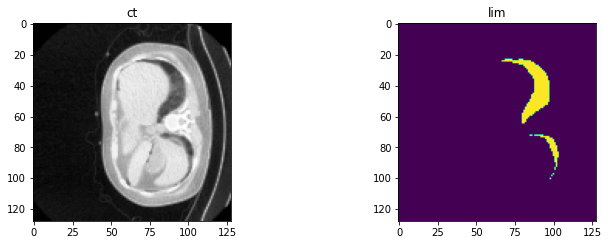

In [ ]:
img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]

n_slice=  random.randint(0, test_mask.shape[2])
print(n_slice) #70
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice,0], cmap='gray')
plt.title('ct')
plt.subplot(222)
plt.imshow(test_mask[:,:,n_slice,0])
plt.title('lim')
plt.show()

In [ ]:
dice_loss = sm.losses.DiceLoss() 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(), sm.losses.DiceLoss(), sm.losses.CategoricalFocalLoss(), sm.losses.JaccardLoss()]
LR = 0.0001
optim = tf.keras.optimizers.Adam(LR)
callbacks = [EarlyStopping(monitor='val_loss', patience=250, verbose=1)]

In [ ]:
steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size

In [ ]:
model = sm.Unet(
                BACKBONE, 
                encoder_weights='imagenet',
                classes = 1,
                activation = 'sigmoid',
                input_shape = (128,128,128,3))

104374272/104360544 [==============================] - 4s 0us/step


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                28, 3)]                                                           
                                                                                                  
 zero_padding3d (ZeroPadding3D)  (None, 134, 134, 13  0          ['input_1[0][0]']                
                                4, 3)                                                             
                                                                                                  
 conv1/conv (Conv3D)            (None, 64, 64, 64,   65856       ['zero_padding3d[0][0]']         
                                64)                                                           

In [ ]:
model.compile(optimizer = optim, loss=total_loss, metrics=metrics)

In [ ]:
history=model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=10000,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          callbacks = callbacks
          )

Epoch 1/10000
15/15 [==============================] - 62s 2s/step - loss: 0.7054 - iou_score: 0.3036 - f1-score: 0.2960 - dice_loss: 0.7040 - focal_loss: 0.0014 - jaccard_loss: 0.8241 - val_loss: 0.7826 - val_iou_score: 0.1121 - val_f1-score: 0.2174 - val_dice_loss: 0.7826 - val_focal_loss: 1.8761e-05 - val_jaccard_loss: 0.8774
Epoch 2/10000
15/15 [==============================] - 13s 855ms/step - loss: 0.6100 - iou_score: 0.5007 - f1-score: 0.3904 - dice_loss: 0.6096 - focal_loss: 4.1524e-04 - jaccard_loss: 0.7550 - val_loss: 0.7733 - val_iou_score: 0.1265 - val_f1-score: 0.2268 - val_dice_loss: 0.7732 - val_focal_loss: 1.4115e-04 - val_jaccard_loss: 0.8714
Epoch 3/10000
15/15 [==============================] - 14s 915ms/step - loss: 0.5541 - iou_score: 0.6135 - f1-score: 0.4462 - dice_loss: 0.5538 - focal_loss: 3.2490e-04 - jaccard_loss: 0.7097 - val_loss: 0.7227 - val_iou_score: 0.2282 - val_f1-score: 0.2844 - val_dice_loss: 0.7156 - val_focal_loss: 0.0071 - val_jaccard_loss: 0.83

In [ ]:
a =history.history['loss']
print(len(a))
#epoch

503


In [ ]:
model.save('/content/drive/MyDrive/3D Segmentation/densenet201unetlung75_tf.h5')

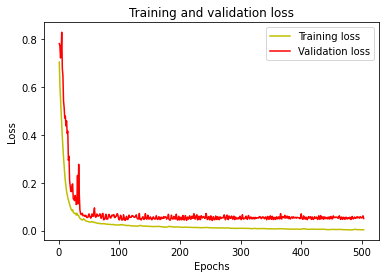

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

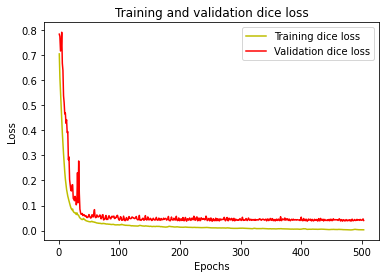

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['dice_loss']
val_loss = history.history['val_dice_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training dice loss')
plt.plot(epochs, val_loss, 'r', label='Validation dice loss')
plt.title('Training and validation dice loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

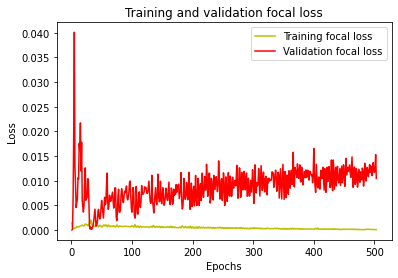

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['focal_loss']
val_loss = history.history['val_focal_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training focal loss')
plt.plot(epochs, val_loss, 'r', label='Validation focal loss')
plt.title('Training and validation focal loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

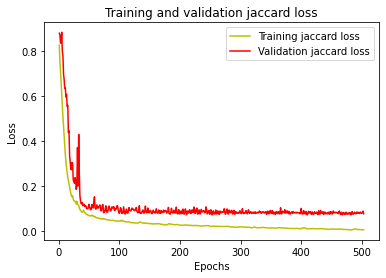

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['jaccard_loss']
val_loss = history.history['val_jaccard_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training jaccard loss')
plt.plot(epochs, val_loss, 'r', label='Validation jaccard loss')
plt.title('Training and validation jaccard loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

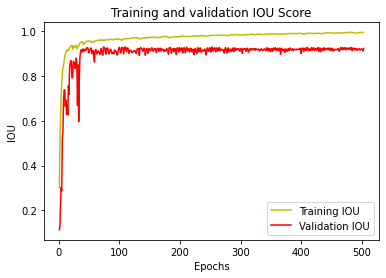

In [ ]:
acc = history.history['iou_score']
val_acc = history.history['val_iou_score']
plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU Score')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

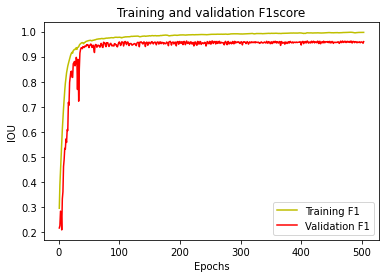

In [ ]:
acc = history.history['f1-score']
val_acc = history.history['val_f1-score']
plt.plot(epochs, acc, 'y', label='Training F1')
plt.plot(epochs, val_acc, 'r', label='Validation F1')
plt.title('Training and validation F1score')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

In [ ]:
imgtest, msktest = val_img_datagen.__next__()

In [ ]:
model.evaluate(imgtest,msktest)

1/1 [==============================] - 4s 4s/step - loss: 0.0679 - iou_score: 0.8932 - f1-score: 0.9428 - dice_loss: 0.0572 - focal_loss: 0.0108 - jaccard_loss: 0.1081


[0.06793347001075745,
 0.8932023644447327,
 0.9428492784500122,
 0.05715072154998779,
 0.010782749392092228,
 0.10812234878540039]

In [ ]:
model = sm.Unet(
                'vgg16', 
                encoder_weights='imagenet',
                classes = 1,
                activation = 'sigmoid',
                input_shape = (128,128,128,3))

In [ ]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                28, 3)]                                                           
                                                                                                  
 block1_conv1 (Conv3D)          (None, 128, 128, 12  5248        ['input_2[0][0]']                
                                8, 64)                                                            
                                                                                                  
 block1_conv2 (Conv3D)          (None, 128, 128, 12  110656      ['block1_conv1[0][0]']           
                                8, 64)                                                      

In [ ]:
model = sm.Unet(
                'densenet201', 
                encoder_weights='imagenet',
                classes = 1,
                activation = 'sigmoid',
                input_shape = (128,128,128,3))

104374272/104360544 [==============================] - 4s 0us/step


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                28, 3)]                                                           
                                                                                                  
 zero_padding3d (ZeroPadding3D)  (None, 134, 134, 13  0          ['input_1[0][0]']                
                                4, 3)                                                             
                                                                                                  
 conv1/conv (Conv3D)            (None, 64, 64, 64,   65856       ['zero_padding3d[0][0]']         
                                64)                                                           

In [ ]:

from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=False)

Output hidden; open in https://colab.research.google.com to view.

In [4]:
from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from keras.metrics import MeanIoU
from keras.preprocessing.image import ImageDataGenerator

In [5]:
kernel_initializer =  'he_uniform'

In [9]:
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
    p1 = MaxPooling3D((2, 2, 2))(c1)
    
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)
     
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
    p3 = MaxPooling3D((2, 2, 2))(c3)
     
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
    p4 = MaxPooling3D(pool_size=(2, 2, 2))(c4)
     
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)
    
    #Expansive path 
    u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)
     
    u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)
     
    u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)
     
    u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)
     
    outputs = Conv3D(num_classes, (1, 1, 1), activation='sigmoid')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    #compile model outside of this function to make it flexible. 
    model.summary()
    
    return model

In [44]:
model=tf.keras.models.Sequential([
                                  
        tf.keras.layers.Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same',input_shape=[128,128,128,3]),
        tf.keras.layers.Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same'),
        tf.keras.layers.Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')
    ])

In [9]:
pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 989 kB 5.1 MB/s 


In [10]:
import visualkeras

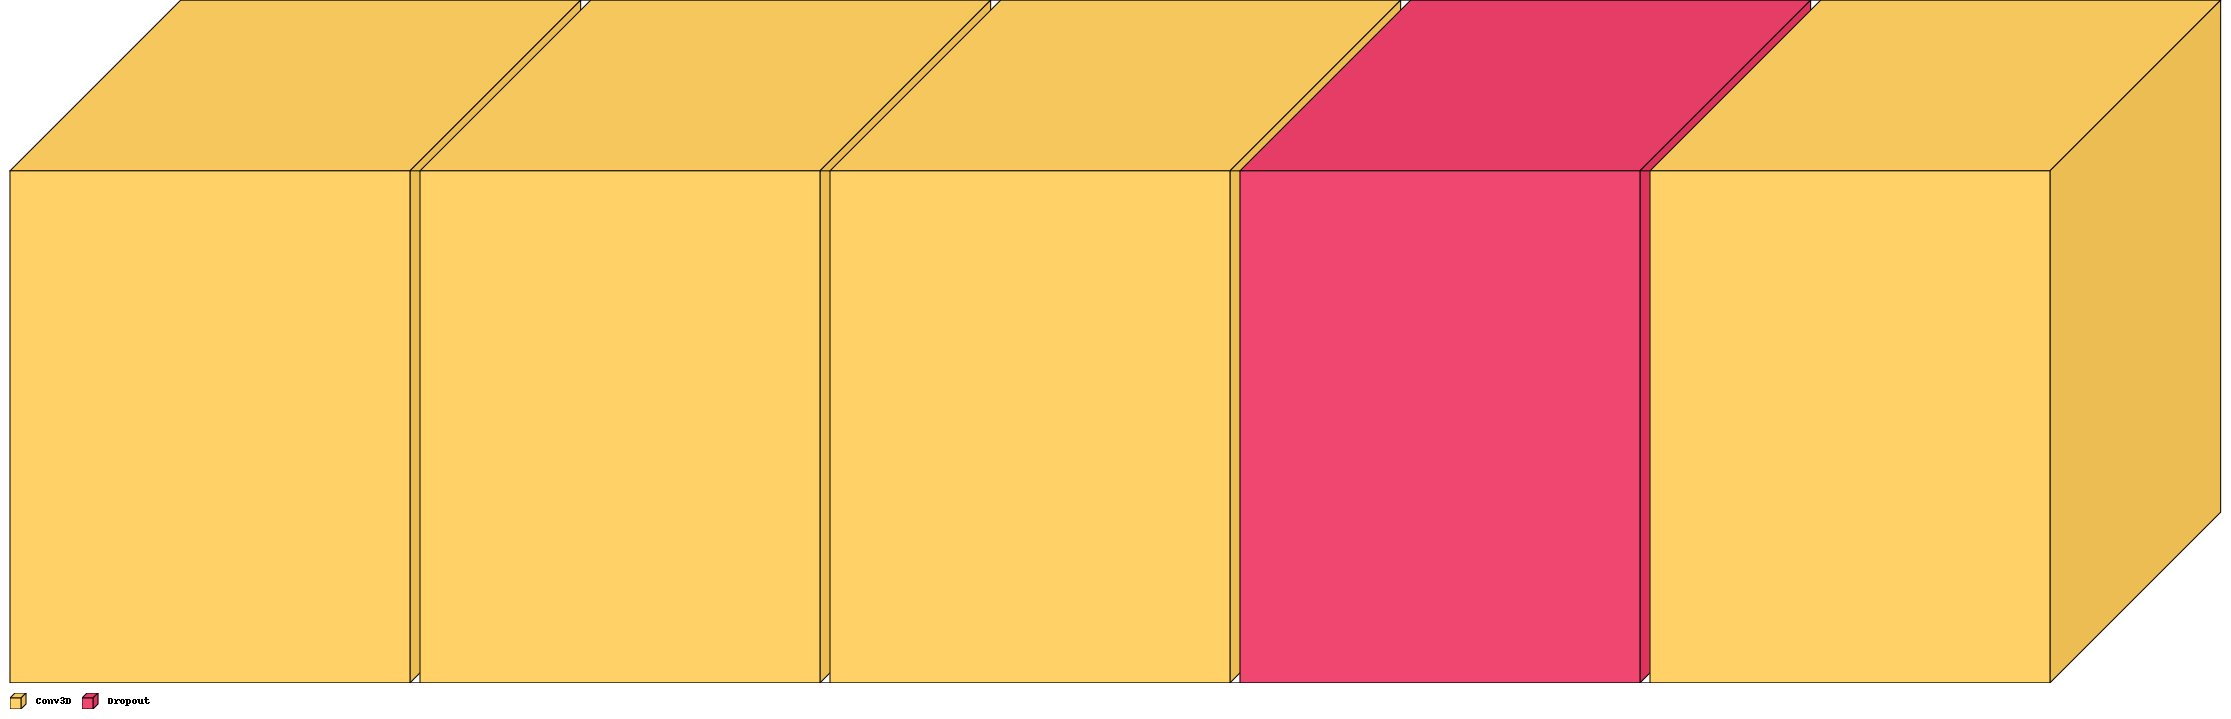

In [45]:
visualkeras.layered_view(model,legend=True, draw_volume=True,to_file='model_plot.png')